In [1]:
%matplotlib inline

from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../../datasets/superstore.csv')

In [3]:
technology = df.loc[df['Category'] == 'Technology']
technology

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,8/27/2014,9/1/2014,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,...,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,1/16/2016,1/20/2016,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,...,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,12/8/2016,12/10/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,9984,US-2016-157728,9/22/2016,9/28/2016,Standard Class,RC-19960,Ryan Crowe,Consumer,United States,Grand Rapids,...,49505,Central,TEC-PH-10001305,Technology,Phones,Panasonic KX TS208W Corded phone,97.980,2,0.0,27.4344
9986,9987,CA-2016-125794,9/29/2016,10/3/2016,Standard Class,ML-17410,Maris LaWare,Consumer,United States,Los Angeles,...,90008,West,TEC-AC-10003399,Technology,Accessories,Memorex Mini Travel Drive 64 GB USB 2.0 Flash ...,36.240,1,0.0,15.2208
9987,9988,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-AC-10001539,Technology,Accessories,Logitech G430 Surround Sound Gaming Headset wi...,79.990,1,0.0,28.7964
9988,9989,CA-2017-163629,11/17/2017,11/21/2017,Standard Class,RA-19885,Ruben Ausman,Corporate,United States,Athens,...,30605,South,TEC-PH-10004006,Technology,Phones,Panasonic KX - TS880B Telephone,206.100,5,0.0,55.6470


In [4]:
technology['Order Date'].min(), technology['Order Date'].max()

('1/10/2016', '9/9/2017')

In [5]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)
technology = technology.sort_values('Order Date')
technology.isnull().sum()


Order Date    0
Sales         0
dtype: int64

In [6]:
technology['Order Date'] = pd.to_datetime(technology['Order Date'])
technology.set_index('Order Date', inplace=True)


In [7]:
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
technology

,Order Date,Sales
0,2014-01-06,1147.940
1,2014-01-09,31.200
2,2014-01-13,646.740
3,2014-01-15,149.950
4,2014-01-16,124.200
...,...,...
819,2017-12-25,401.208
820,2017-12-27,164.388
821,2017-12-28,14.850
822,2017-12-29,302.376


In [8]:
technology = technology.set_index('Order Date')
technology.index


DatetimeIndex(['2014-01-06', '2014-01-09', '2014-01-13', '2014-01-15',
               '2014-01-16', '2014-01-20', '2014-01-26', '2014-02-01',
               '2014-02-02', '2014-02-06',
               ...
               '2017-12-18', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)

In [9]:
y = technology['Sales'].resample('MS').mean()


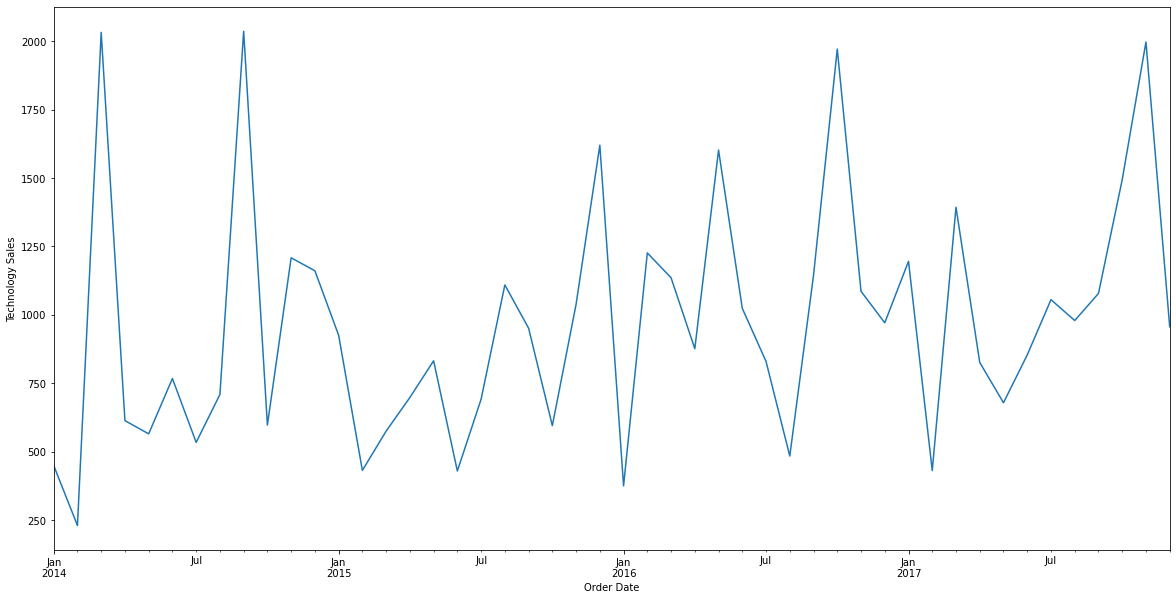

In [10]:
y.plot(figsize=(20,10))
plt.xlabel("Order Date")
plt.ylabel("Technology Sales")
plt.show()

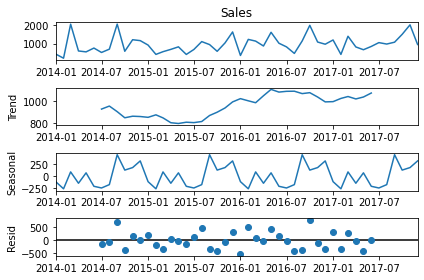

In [11]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

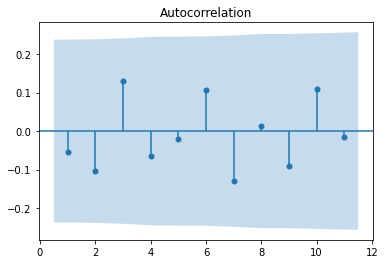

In [12]:
plot_acf(y, lags=range(1,12), alpha=0.1);

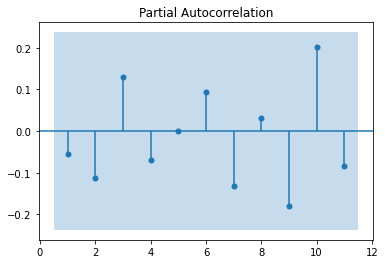

In [13]:
plot_pacf(y, lags=range(1,12), alpha=0.1);

In [14]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(y, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.187969e+00
P-Value                 2.547334e-10
# Lags Used             0.000000e+00
# Observations Used     4.700000e+01
Critical Value (1%)    -3.577848e+00
Critical Value (5%)    -2.925338e+00
Critical Value (10%)   -2.600774e+00
dtype: float64


In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:791.4891765009955
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1190.0722745941837
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:549.0156237882128
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:356.47255193969687
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:564.1031529698099
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1450.3835194600476
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.6612068172691
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:357.88452536987006
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:750.8969484750909
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2565.2761223816688
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:535.0489454747744
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:341.18923596701177
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:566.0827904028115
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2601.409087836188
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:373.8760065868644
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:342.63073634199316
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:729.3478530237927
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1372.105636627768
ARI

In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1650      0.284     -0.582      0.561      -0.721       0.391
ma.L1         -1.0001      4.261     -0.235      0.814      -9.351       7.350
ar.S.L12      -0.0889      0.222     -0.401      0.689      -0.523       0.346
ma.S.L12      -1.0804      3.934     -0.275      0.784      -8.792       6.631
sigma2      1.423e+05   3.09e-05   4.61e+09      0.000    1.42e+05    1.42e+05


In [18]:
residuals = pd.Series(results.resid)

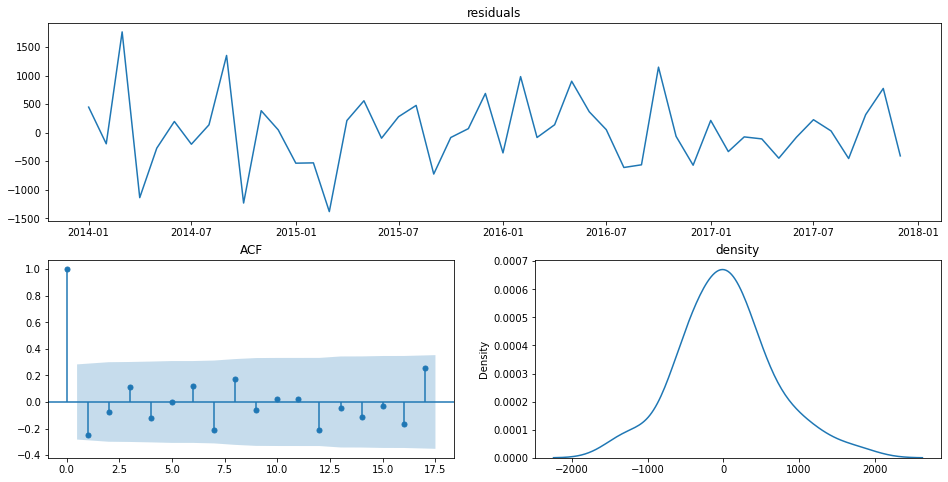

In [19]:
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals)

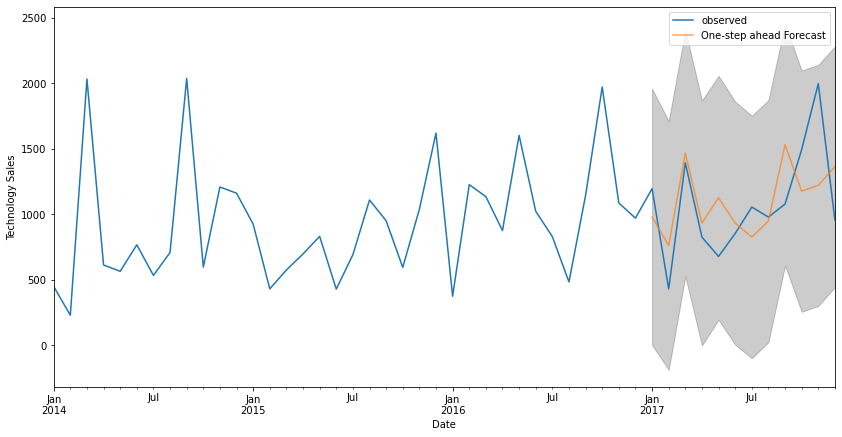

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 125442.22


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 354.18


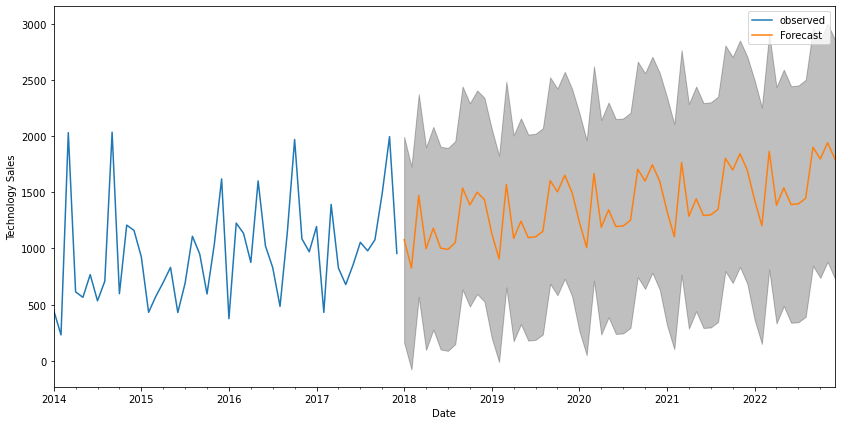

In [27]:
pred_uc = results.get_forecast(steps=60)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Technology Sales')
plt.legend()
plt.show()